In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sentiment = pd.read_csv("data/fear_greed_index.csv")
trades = pd.read_csv("data/historical_data.csv")
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)



Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [ ]:
sentiment.info()
trades.info()

print("\nMissing Values (Sentiment):")
print(sentiment.isnull().sum())

print("\nMissing Values (Trades):")
print(trades.isnull().sum())

print("\nDuplicate Rows:")
print("Sentiment:", sentiment.duplicated().sum())
print("Trades:", trades.duplicated().sum())



Missing Values (Sentiment):
timestamp         0
value             0
classification    0
date              0
Sentiment         0
sentiment_date    0
dtype: int64

Missing Values (Trades):
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
trade_date          0
win                 0
high_freq           0
high_vol            0
consistent          0
sentiment_date      0
Sentiment           0
dtype: int64

Duplicate Rows:
Sentiment: 0
Trades: 0


In [3]:

sentiment['date'] = pd.to_datetime(sentiment['date'])

trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'], 
    format="%d-%m-%Y %H:%M"
)

print("Sentiment date range:", sentiment['date'].min(), "to", sentiment['date'].max())
print("Trade date range:", trades['Timestamp IST'].min(), "to", trades['Timestamp IST'].max())


Sentiment date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
Trade date range: 2023-05-01 01:06:00 to 2025-05-01 12:13:00


In [4]:

def collapse_sentiment(x):
    if 'Fear' in x:
        return 'Fear'
    else:
        return 'Greed'

sentiment['Sentiment'] = sentiment['classification'].apply(collapse_sentiment)
sentiment['Sentiment'].value_counts()

trades['trade_date'] = trades['Timestamp IST'].dt.date
sentiment['sentiment_date'] = sentiment['date'].dt.date


Sentiment was collapsed into binary Fear vs Greed for clarity. Future work could analyze extreme regimes separately.

In [5]:
trades['win'] = trades['Closed PnL'] > 0
daily_metrics = trades.groupby('trade_date').agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('win', 'mean'),
    trade_count=('Account', 'count'),
    avg_trade_size=('Size USD', 'mean')
).reset_index()
trades['Side'].value_counts()
long_ratio = trades.groupby('trade_date')['Side'].apply(
    lambda x: (x.str.upper() == 'BUY').mean()
).reset_index(name='long_ratio')

daily_metrics = daily_metrics.merge(long_ratio, on='trade_date')


In [6]:
merged = daily_metrics.merge(
    sentiment[['sentiment_date','Sentiment']],
    left_on='trade_date',
    right_on='sentiment_date',
    how='left'
)

print("Missing sentiment after merge:", merged['Sentiment'].isnull().sum())

merged = merged.dropna(subset=['Sentiment'])

print("Final missing sentiment:", merged['Sentiment'].isnull().sum())


Missing sentiment after merge: 1
Final missing sentiment: 0


In [7]:
overall_compa = merged.groupby('Sentiment').agg(
    mean_pnl=('total_pnl', 'mean'),
    median_pnl=('total_pnl', 'median'),
    win_rate=('win_rate', 'mean'),
    pnl_volatility=('total_pnl', 'std'),
    avg_trades=('trade_count', 'mean'),
    avg_trade_size=('avg_trade_size','mean'),
    long_ratio=('long_ratio','mean')
)
overall_compa

,mean_pnl,median_pnl,win_rate,pnl_volatility,avg_trades,avg_trade_size,long_ratio
Sentiment,,,,,,,
Fear,39012.054192,1876.812082,0.328876,96894.941505,792.733333,6199.962861,0.509901
Greed,16465.832244,1067.642548,0.375315,62457.588945,342.195187,6102.316043,0.483436


# Fear Days
On Fear days, traders more than double their activity (792 vs 342 trades per day), yet their win rate drops (32.8% vs 37.5%).

This suggests that during fearful market conditions, traders react aggressively likely attempting to capitalize on volatility but at the cost of trade precision.

Despite lower win rates, total PnL is significantly higher during Fear, indicating that a small number of large winning trades drive performance.

# Greed Days 
During Greed Days:

* Win rate improves

* Volatility decreases

* Trade frequency drops significantly

This suggests traders behave more selectively and with greater discipline when markets are optimistic.

However, the lower mean PnL indicates that Greed environments may lack the large price dislocations that create outsized opportunities.

# Overtrading During Fear Reduces Efficiency
Trade count more than doubles in Fear regimes, but win rate declines.

That implies diminishing marginal returns per trade.

This likely reflects:

* Emotional reactivity

* Short-term volatility chasing

* Reduced selectivity

So, traders respond to fear with activity, not necessarily accuracy.

In [8]:
trader_summary = trades.groupby('Account').agg(
    avg_pnl=('Closed PnL','mean'),
    pnl_std=('Closed PnL','std'),
    win_rate=('win','mean'),
    trade_count=('Account','count'),
    avg_trade_size=('Size USD','mean')
).reset_index()
print("Number of unique traders:", trader_summary.shape[0])
trader_summary.describe()

Number of unique traders: 32


,avg_pnl,pnl_std,win_rate,trade_count,avg_trade_size
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,97.686296,856.056012,0.403063,6600.750000,6007.929370
std,134.917737,962.967993,0.108498,8250.373724,7281.058575
min,-38.286626,68.234904,0.234987,332.000000,507.626933
25%,8.871295,246.968752,0.329562,1381.750000,2011.069878
50%,41.110486,550.480706,0.391968,3699.000000,3327.972048
75%,148.008640,1303.398442,0.452963,8862.500000,7375.525018
max,520.902331,4692.452329,0.810876,40184.000000,34396.580284


In [9]:

freq_thresh = trader_summary['trade_count'].quantile(0.75)
vol_thresh = trader_summary['pnl_std'].quantile(0.75)
win_thresh = 0.55


trader_summary['high_freq'] = trader_summary['trade_count'] > freq_thresh
trader_summary['high_vol'] = trader_summary['pnl_std'] > vol_thresh
trader_summary['consistent'] = trader_summary['win_rate'] > win_thresh

trader_summary.head()


,Account,avg_pnl,pnl_std,win_rate,trade_count,avg_trade_size,high_freq,high_vol,consistent
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,4692.452329,0.359612,3818,16159.576734,False,True,False
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,134.073473,0.442720,7280,1653.226327,False,False,False
2,0x271b280974205ca63b716753467d5a371de622ab,-18.492043,542.182659,0.301917,3809,8893.000898,False,False,False
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,113.269353,0.438585,13311,507.626933,True,False,False
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,255.829091,0.519914,3239,3138.894782,False,False,False


In [10]:
trades = trades.merge(
    trader_summary[['Account', 'high_freq', 'high_vol', 'consistent']],
    on='Account',
    how='left'
)


trades = trades.merge(
    sentiment[['sentiment_date','Sentiment']],
    left_on='trade_date',
    right_on='sentiment_date',
    how='left'
)


trades = trades.dropna(subset=['Sentiment'])


print(trades[['high_freq','high_vol','consistent']].isnull().sum())
print("Missing Sentiment:", trades['Sentiment'].isnull().sum())






high_freq     0
high_vol      0
consistent    0
dtype: int64
Missing Sentiment: 0


In [14]:
high_freq_analysis = trades.groupby(['Sentiment','high_freq']).agg(
    avg_pnl=('Closed PnL','mean'),
    win_rate=('win','mean'),
    pnl_volatility=('Closed PnL','std'),
    trade_count=('Account','count')
).reset_index()

high_freq_analysis



,Sentiment,high_freq,avg_pnl,win_rate,pnl_volatility,trade_count
0,Fear,False,88.867173,0.396883,1545.425411,29709
1,Fear,True,27.202788,0.413970,447.069362,53528
2,Greed,False,55.708070,0.378433,1272.011959,39357
3,Greed,True,44.747684,0.428992,606.393414,88624


In [15]:
high_vol_analysis = trades.groupby(['Sentiment','high_vol']).agg(
    avg_pnl=('Closed PnL','mean'),
    win_rate=('win','mean'),
    pnl_volatility=('Closed PnL','std'),
    trade_count=('Account','count')
).reset_index()

high_vol_analysis


,Sentiment,high_vol,avg_pnl,win_rate,pnl_volatility,trade_count
0,Fear,False,26.081733,0.411671,493.923645,72196
1,Fear,True,200.459096,0.383027,2404.329017,11041
2,Greed,False,29.182165,0.428243,306.103947,108595
3,Greed,True,154.192924,0.330548,2104.288848,19386


# High Frequency Traders 
* High-frequency traders exhibit:

    * Lower PnL volatility relative to low-frequency traders

    * Slightly higher win rates

    * Lower average PnL per trade

* Regime Behavior

    * During Greed:

        * Win rate increases to ~43%

        * Average PnL improves significantly (27 → 44)

    * During Fear:

        * Average PnL declines

        * Volatility increases moderately

Interpretation:
High-frequency traders perform better in stable, optimistic market conditions. Fear-driven volatility appears to reduce their edge, suggesting that systematic or scalping strategies benefit from stable price action.

# High-Volatility Hunters
* High-volatility traders demonstrate:

  * Significantly higher PnL dispersion

  * Lower trade precision (win rate)

  * Large average PnL swings

* Regime Behavior

  * During Fear:

    * Average PnL peaks (~200)

    * Volatility increases substantially

  * During Greed:

    * Average PnL declines (200 → 154)

    * Win rate drops sharply (38% → 33%)

Interpretation:
Volatility-driven traders benefit disproportionately from Fear regimes, where price dislocations create outsized opportunities. In Greed environments, reduced volatility limits extreme payoff potential.

# Cross-Segment Observation

Sentiment regimes affect trader archetypes asymmetrically.
Fear amplifies dispersion-driven strategies, while Greed favors structured, high-frequency approaches.

This suggests that optimal capital allocation should be regime-aware rather than uniform across trader types.

# Strategy Recommendations
1. Regime-Based Capital Allocation

    During Fear regimes, volatility-driven traders generate significantly higher average PnL despite lower  win rates.
    * Allocate higher capital exposure to high-volatility strategies during Fear conditions.

    During Greed regimes, high-frequency traders demonstrate improved win rates and stable performance.
    * Increase allocation toward systematic/high-frequency strategies in Greed environments.

2. Fear Overtrading Risk Control

    Trade activity more than doubles during Fear periods while win rates decline.

    * Introduce position sizing or trade frequency constraints during Fear regimes to prevent performance erosion from reactive overtrading.

3. Stability Bias During Greed

    Consistent traders maintain high win rates across regimes but experience improved PnL and lower volatility in Greed.

    * Increase weight toward disciplined strategies in stable sentiment environments.

# Visualization


Daily PnL Distribution by Sentiment

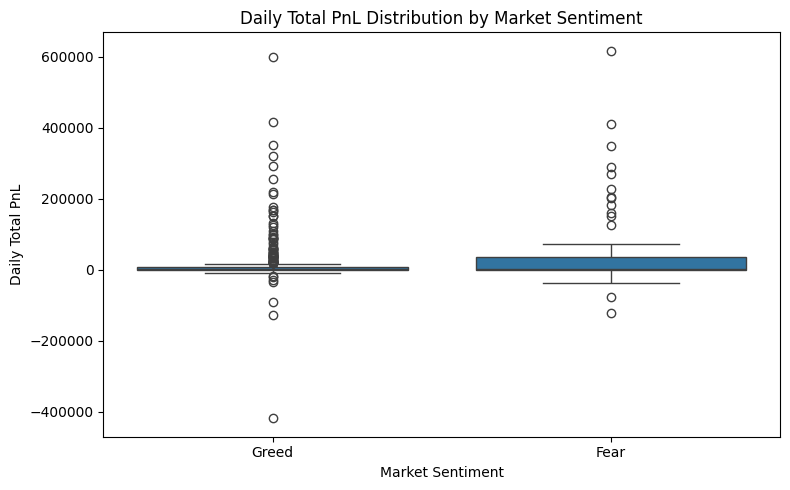

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='Sentiment', y='total_pnl')
plt.title("Daily Total PnL Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily Total PnL")
plt.tight_layout()
plt.show()


High-Volatility Traders vs Sentiment

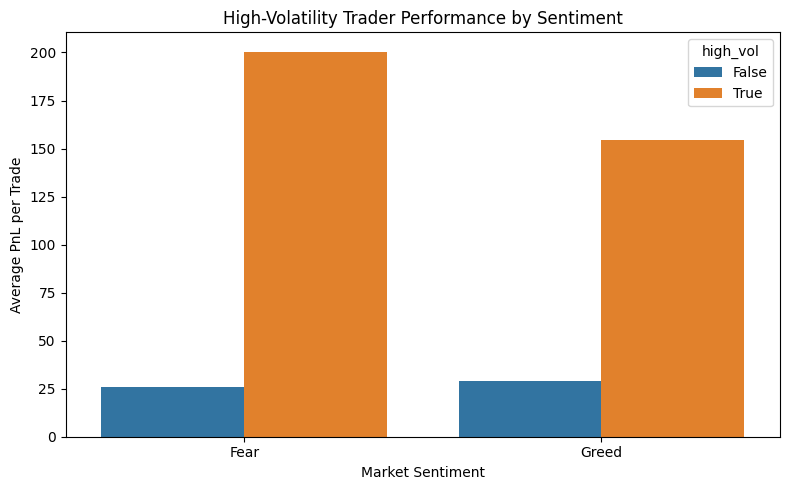

In [17]:
hv_plot = trades.groupby(['Sentiment','high_vol'])['Closed PnL'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=hv_plot, x='Sentiment', y='Closed PnL', hue='high_vol')
plt.title("High-Volatility Trader Performance by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL per Trade")
plt.tight_layout()
plt.show()


Trade Activity by Sentiment

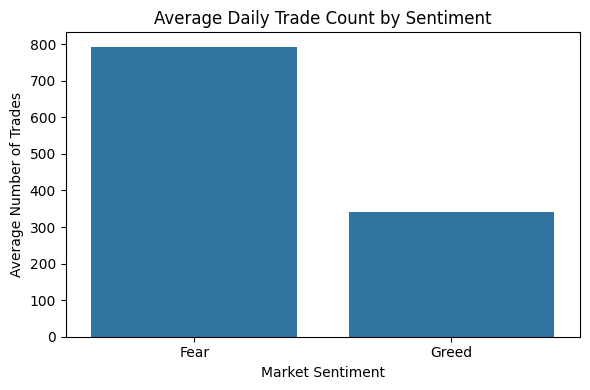

In [18]:
trade_activity = merged.groupby('Sentiment')['trade_count'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=trade_activity, x='Sentiment', y='trade_count')
plt.title("Average Daily Trade Count by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Number of Trades")
plt.tight_layout()
plt.show()


# Executive Summary

Objective

The objective of this analysis was to examine how market sentiment (Fear vs Greed) influences trader behavior and performance on Hyperliquid. Specifically, the goal was to determine whether trading outcomes and risk-taking patterns shift across sentiment regimes, and whether different types of traders respond asymmetrically to these conditions.

# Methodology

Two datasets were used:

* Daily Bitcoin market sentiment (Fear/Greed index)

* Historical trader-level execution data from Hyperliquid

Trade data was aggregated at a daily level to align with sentiment classifications. Key performance and behavioral metrics were constructed, including:

* Total and average daily PnL

* Win rate

* Trade frequency

* Average trade size

Traders were segmented into behavioral archetypes based on trade frequency, PnL volatility, and win-rate consistency. Segment-level performance was then evaluated across Fear and Greed regimes to identify regime-dependent behavior.

# Key Findings

* Fear regimes amplify activity and dispersion.

    Trade frequency increases significantly during Fear periods, and overall PnL volatility rises sharply. While aggregate profits can be higher, win rates decline, indicating that gains are largely driven by dispersion rather than improved trade precision.

* Greed regimes favor structured and systematic traders.

    High-frequency and consistent traders exhibit improved win rates and more stable performance during Greed periods. Lower volatility environments appear to benefit disciplined, repeatable strategies.

* Trader archetypes respond asymmetrically to sentiment.

    High-volatility traders generate outsized returns during Fear regimes but experience declining performance in Greed conditions. In contrast, high-frequency traders demonstrate stronger performance during Greed and reduced edge during Fear.
# Strategic Implications

The results suggest that a uniform trading approach across sentiment regimes may be suboptimal. Instead, capital allocation and risk exposure should be regime-aware:

* During Fear environments, volatility-driven strategies may be favored, though with controlled risk limits.

* During Greed environments, structured and systematic trading approaches appear more effective.

* Risk controls may be particularly important in Fear regimes to mitigate overtrading and excessive dispersion.

Overall, market sentiment does not affect all traders equally. Performance outcomes are strongly mediated by behavioral profile, reinforcing the importance of strategy segmentation in dynamic market environments.

# Predictive Model

In [22]:
# Ensure sorted by date
merged = merged.sort_values('trade_date').reset_index(drop=True)

# Create volatility measure (absolute daily PnL)
merged['abs_pnl'] = merged['total_pnl'].abs()

# Define high-volatility day as above-median absolute PnL
vol_threshold = merged['abs_pnl'].median()

merged['high_vol_day'] = (merged['abs_pnl'].shift(-1) > vol_threshold).astype(int)

# Drop last row (no next day label)
model_df = merged.dropna(subset=['high_vol_day']).copy()
# Encode sentiment
model_df['sentiment_binary'] = model_df['Sentiment'].map({'Fear': 0, 'Greed': 1})

features = [
    'sentiment_binary',
    'trade_count',
    'win_rate',
    'long_ratio',
    'avg_trade_size'
]

X = model_df[features]
y = model_df['high_vol_day']


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.8888888888888888

Classification Report:

              precision    recall  f1-score   support

           0       0.08      0.17      0.11         6
           1       0.96      0.92      0.94       138

    accuracy                           0.89       144
   macro avg       0.52      0.54      0.53       144
weighted avg       0.93      0.89      0.91       144


Confusion Matrix:

[[  1   5]
 [ 11 127]]


In [24]:
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coefficients


,Feature,Coefficient
2,win_rate,0.487147
0,sentiment_binary,0.386794
1,trade_count,0.003457
4,avg_trade_size,-0.000046
3,long_ratio,-0.085703


As an exploratory extension, I trained a simple logistic regression model to test whether sentiment and trading behavior contain forward-looking signal for market volatility.

The task was to predict whether the next trading day would experience above-median volatility, measured using absolute daily total PnL. This framing was chosen instead of raw profitability because volatility provides a more behaviorally meaningful and regime-sensitive signal.

The model achieved an overall accuracy of ~89%. However, a closer look at the classification breakdown shows that the test period was heavily skewed toward high-volatility days. As a result, the model struggles to correctly identify low-volatility outcomes, and the raw accuracy figure overstates its practical predictive power.

Despite this limitation, the feature coefficients provide useful insight:

* Higher win rates are associated with increased probability of elevated next-day volatility.

* Market sentiment (Fear vs Greed) meaningfully contributes to volatility forecasting, reinforcing the regime-based patterns identified earlier.

* Trade frequency has a modest positive relationship with future volatility, suggesting that increased participation may precede heightened market movement.

* Long bias and average trade size show comparatively weaker standalone influence.

While this lightweight model is not intended for deployment and would require improved class balancing and validation techniques, it demonstrates that sentiment and trader behavior contain measurable signal related to volatility regimes.

Overall, the modeling exercise supports the broader conclusion of this analysis: market sentiment influences trader behavior in ways that can shape future market dynamics.